In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil --q
!pip install psutil --q
!pip install humanize --q
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 26.4 GB  | Proc size: 159.3 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


# 1. Setup

In [0]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive/"     # default location for the drive
drive.mount(ROOT)           # we mount the google drive at /content/drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## 1.1 Using Colab GPU for training

In [0]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## 1.2 Install Hugging Face library

In [0]:
!pip install transformers --q

     |████████████████████████████████| 645kB 3.4MB/s 
     |████████████████████████████████| 1.1MB 15.1MB/s 
     |████████████████████████████████| 890kB 23.5MB/s 
     |████████████████████████████████| 3.8MB 30.4MB/s 


# 2. Load Indonesian News Dataset

Topic : bola, news, bisnis, tekno, otomotif

In [0]:
# dict mapping
label2num = {'bola':0, 'news':1, 'bisnis':2, 'tekno':3, 'otomotif':4}

In [0]:
import pickle

data_path = 'drive/My Drive/DSI/data/'
train_path = data_path+'training.res'
test_path = data_path+'testing.res'

train = pickle.load(open(train_path, 'rb'))
test = pickle.load(open(test_path, 'rb'))

In [0]:
import pandas as pd

train = pd.DataFrame({'text': train[0], 'label': train[1]})
test = pd.DataFrame({'text': test[0], 'label': test[1]})

print('Number of training sentences: {:,}\n'.format(train.shape[0]))
print('Number of testing sentences: {:,}\n'.format(test.shape[0]))

# Display 5 random rows from the data.
train.sample(5)

Number of training sentences: 6,127

Number of testing sentences: 2,627



,text,label
1061,"Liputan6.com, Turin - Sassuolo tak berdaya men...",bola
1657,"Liputan6.com, Jakarta - Penyidik Polres Metro ...",news
99,"Liputan6.com, Jakarta Timnas Indonesia U-22 ba...",bola
1163,"Liputan6.com, Chicago - Harga emas turun pada ...",bisnis
5875,"Liputan6.com, London - Partai perdelapan final...",bola


In [0]:
# encode label
train.label = train.label.map(label2num)
test.label = test.label.map(label2num)

# Data Cleansing

In [0]:
from nltk.tokenize import word_tokenize
import nltk
import collections
nltk.download('punkt')

def get_frequent_word(df):
    text = " ".join(list(df['text'].str.lower()))
    word_list = word_tokenize(text)
    word_count = dict(collections.Counter(word_list))
    d_word_freq = pd.DataFrame(data = {'word': list(word_count.keys()), 'freq': list(word_count.values())})
    
    return d_word_freq

def cleansing(text, stopword = None):
    word_list = word_tokenize(text.lower())
    word_list = [word for word in word_list if len(word) > 2]
    word_list = [word for word in word_list if word.isalnum()]
    if stopword == None:
        text = ' '.join(word_list)
    else:
        word_list = [word for word in word_list if word not in stopword]
        text = ' '.join(word_list)
                
    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
# Get frekuensi kemunculan kata
d_w_f = get_frequent_word(train)
# Check alphanumeric
d_w_f['is_alnum'] = d_w_f.word.str.isalnum()
# select only alphanumeric word (ignore punctuation)
d_w_f_selected = d_w_f[d_w_f['is_alnum'] == True].sort_values(by = 'freq', ascending = False)
print(d_w_f_selected.head(15))
print(d_w_f_selected.tail(15))

          word   freq  is_alnum
60        yang  22988      True
43          di  22859      True
96         dan  18465      True
21         ini  12634      True
109     dengan  10181      True
72       untuk  10092      True
29        dari   8955      True
134        itu   8409      True
35        pada   7787      True
83     jakarta   7029      True
79        akan   6789      True
203      dalam   6527      True
76       tidak   5392      True
33        juga   4838      True
236  indonesia   4691      True
              word  freq  is_alnum
27517      cimarga     1      True
27518     menganga     1      True
27520        sardi     1      True
27524  diposanjoyo     1      True
27525       mangun     1      True
27526        jak59     1      True
27539          uki     1      True
27541        penas     1      True
27560      bromley     1      True
27561       ngebut     1      True
27564      palermo     1      True
27565         naum     1      True
27570    seketaris     1      Tru

In [0]:
# Create stopwords list
stopwords = list(d_w_f_selected[(d_w_f_selected['freq'] > 5000) | (d_w_f_selected['freq'] < 2)].word)
print(stopwords[:10])

['yang', 'di', 'dan', 'ini', 'dengan', 'untuk', 'dari', 'itu', 'pada', 'jakarta']


In [0]:
from tqdm import tqdm

for i in tqdm(range(len(train))):
    train.loc[i, 'text_cleansing'] = cleansing(train.loc[i, 'text'], stopword=stopwords)

for i in tqdm(range(len(test))):
    test.loc[i, 'text_cleansing'] = cleansing(test.loc[i, 'text'], stopword=stopwords)

100%|██████████| 2627/2627 [01:58<00:00, 22.16it/s]


In [0]:
# Training data only use 4000 sentences
sentences = train.text_cleansing.values[:4000]
labels = train.label.values[:4000]

# Testing data only use 1000 sentence
test_sentences = test.text_cleansing.values[:1000]
test_labels = test.label.values[:1000]

# 3. Tokenization & Input Formatting

## 3.1 BERT Tokenizer

In [0]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

Loading BERT tokenizer...


## 3.2 Required Formatting

We are required to:

1.   Tambah special tokens di awal dan akhir setiap kalimat
2.   Pad or truncate semua kalimat ke length tertentu
3.   Prepare "attention mask"

### Special Tokens


**`[SEP]`**

Pada akhir setiap kalimat, kita perlu menambahkan `[SEP]` token.

**`[CLS]`**

Untuk classification tasks, kita harus menambahkan `[CLS]` token ke setiap awal kalimat.

![Illustration of CLS token purpose](http://www.mccormickml.com/assets/BERT/CLS_token_500x606.png)

On the output of the final (12th) transformer, *only the first embedding (corresponding to the [CLS] token) is used by the classifier*.

>  "The first token of every sequence is always a special classification token (`[CLS]`). The final hidden state
corresponding to this token is used as the aggregate sequence representation for classification
tasks." (from the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))



### Sentence Length & Attention Mask

Panjang kalimat dalam dataset sangat bervariasi, jadi gimana cara-nya BERT handle ini ?

BERT punya 2 batasan :
1. Semua kalimat harus di pad atau truncate menjadi satu fixed length
2. Max sentence length is 512 tokens

Padding menggunakan special token `[PAD]`

<img src="http://www.mccormickml.com/assets/BERT/padding_and_mask.png" width="600">

"Attention Mask" adalah array yang terdiri dari '1' dan '0' dimana '1' mengindikasikan token tsb adalah padding dan '0' yang bukan. Mask ini memberitahu  pada "Self-Attention" pada BERT untuk tidak memasukkan token `[PAD]` ini saat menginterpretasikan kalimat





## 3.3 Tokenize Dataset

In [0]:
import statistics
sent_length = []

# For every sentence...
for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    sent_length.append(len(input_ids))

print('Average length = ', sum(sent_length)/len(sent_length))
print('Median length = ', statistics.median(sent_length))

Token indices sequence length is longer than the specified maximum sequence length for this model (777 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (748 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (988 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (634 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Average length =  232.984
Median length =  218.0


Max length di set menjadi 256.

Fungsi `tokenizer.encode_plus` melakukan beberapa langkah :

1. Split kalimat jadi token.
2. Tambah special token (`[CLS]` and `[SEP]`)
3. Mapping token menjadi ID
4. Pad atau truncate semua kalimat menjadi same length.
5. Buat attention mask

Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [0]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  london lee dixon khawatir arsenal tak bisa merekrut denis suarez secara permanen musim panas nanti pasalnya sejauh suarez hanya menjadi cadangan bagi the gunners suarez dipinjam arsenal barcelona januari lalu the gunners juga bisa membelinya akhir musim nanti jika permainannya memuaskan namun sejauh suarez tak menjadi pilihan utama arsenal manajer unai emery baru memberinya kesempatan bermain selama menit emery mungkin tahu kualitas suarez dia tahu suarez pemain kata dixon seperti dilansir evening standard namun sudut pandang suarez dia pasti berpikir apa pindah kalau bermain jadi mungkin saja dia menolak arsenal katanya menambahkan
Token IDs: tensor([   101,  10406,  10605,  10115,  10141,  10112, 105154,  10115,    179,
        101917,  13259,  10129,  10456,  62191,  10161,  12741,  17103,  22336,
         63051,  11159,  10140,  10291,  10603,  34305,  14635,  10178,  38154,
         10115,  25386,  53215,  10799,  10325,  26088,  27302,  10113,  27271,
         18593,  

## 3.4. Training & Validation Split

In [0]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,200 training samples
  800 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model

## 4.1. BertForSequenceClassification



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased', # Use the 12-layer BERT model, with an cased vocab.
    num_labels = 5, 
    output_attentions = False, # return attentions weights
    output_hidden_states = False, # returns all hidden-states
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

Show model parameters

In [0]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

## 4.2. Optimizer & Learning Rate Scheduler

Untuk fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 3

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8
                )

In [0]:
from transformers import get_linear_schedule_with_warmup

epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
print('Jumlah batch :', len(train_dataloader))
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Jumlah batch : 100


`get_linear_schedule_with_warmup` function :
Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period.

## 4.3. Training Loop

**Training:**
- Unpack our data inputs and labels
- Load data to GPU
- Clear out the gradients calculated in the previous pass. 
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data to GPU
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Define a helper function for calculating accuracy.

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Ready to kick off the training!

In [0]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# List variable for store training and validation loss, validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 20 batches.
        if step % 20 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # token_type_ids is same as the "segment ids", which differentiates 
        # sentence 1 and 2 in sentence-pair tasks
        loss, logits = model(b_input_ids, 
                             token_type_ids=None,
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. 
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode (batchnorm, dropout disable)
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Deactivate autograd, it will reduce memory usage and speed up computations
        # but you won’t be able to backprop (which you don’t want in an eval script).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'Epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Validation Loss': avg_val_loss,
            'Validation Accuracy': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  Batch    20  of    100.    Elapsed: 0:00:16.
  Batch    40  of    100.    Elapsed: 0:00:31.
  Batch    60  of    100.    Elapsed: 0:00:46.
  Batch    80  of    100.    Elapsed: 0:01:01.

  Average training loss: 0.69
  Training epoch took: 0:01:17

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.36
  Validation took: 0:00:06

======== Epoch 2 / 3 ========
Training...
  Batch    20  of    100.    Elapsed: 0:00:15.
  Batch    40  of    100.    Elapsed: 0:00:30.
  Batch    60  of    100.    Elapsed: 0:00:46.
  Batch    80  of    100.    Elapsed: 0:01:01.

  Average training loss: 0.29
  Training epoch took: 0:01:16

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.30
  Validation took: 0:00:06

======== Epoch 3 / 3 ========
Training...
  Batch    20  of    100.    Elapsed: 0:00:15.
  Batch    40  of    100.    Elapsed: 0:00:30.
  Batch    60  of    100.    Elapsed: 0:00:46.
  Batch    80  of    100.    Elapsed: 0:01:01.

  Average training loss: 0.20
  Training ep

Let's view the summary of the training process.

In [0]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('Epoch')

# Display the table.
df_stats

,Training Loss,Validation Loss,Validation Accuracy,Training Time,Validation Time
Epoch,,,,,
1,0.69,0.36,0.88,0:01:17,0:00:06
2,0.29,0.30,0.90,0:01:16,0:00:06
3,0.20,0.28,0.91,0:01:16,0:00:06


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


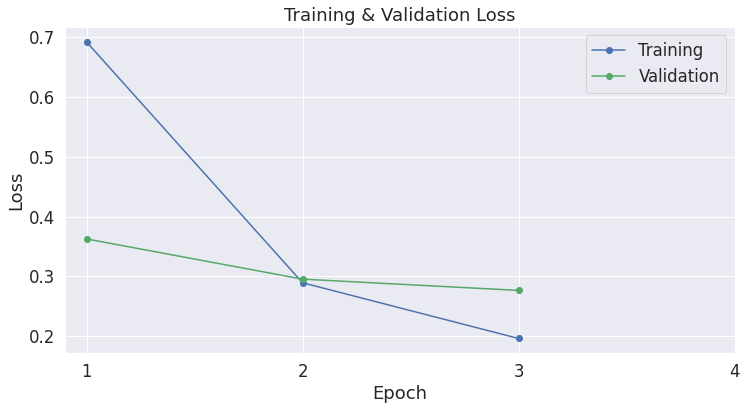

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Validation Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Performance On Test Set

### 5.1. Data Preparation

In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in test_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## 5.2. Evaluate on Test Set


With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [0]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,000 test sentences...
    DONE.


In [0]:
# Calculate accuracy for test dataset
total_accuracy = 0
for batch_num in range(len(predictions)): 
  total_accuracy += flat_accuracy(predictions[batch_num], true_labels[batch_num])

total_accuracy = total_accuracy/len(predictions)*100
print('Accuracy on test dataset:', total_accuracy)

Accuracy on test dataset: 92.7734375


# Saving Model

In [0]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = 'drive/My Drive/DSI/model/'

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to drive/My Drive/DSI/model/


('drive/My Drive/DSI/model/vocab.txt',
 'drive/My Drive/DSI/model/special_tokens_map.json',
 'drive/My Drive/DSI/model/added_tokens.json')

# Load Model back from disk

In [0]:
# Load a trained model and vocabulary that you have fine-tuned
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen